In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [3]:
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [4]:
data_dir = '../../../data/'

In [5]:
subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

In [6]:
#threshold for voxels (based on split-half reliability)
thresh = 0.2

In [7]:
with open('rh_betas_by_repeat_by_ROI_zscore.data', 'rb') as filehandle:
    # read the data as binary data stream
    rh_betas_by_repeat_by_ROI = pickle.load(filehandle)

FileNotFoundError: [Errno 2] No such file or directory: 'rh_betas_by_repeat_by_ROI_zscore.data'

In [8]:
rh_betas_by_repeat_by_ROI[7][6][2].shape

NameError: name 'rh_betas_by_repeat_by_ROI' is not defined

In [8]:
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = '../../../local_data/freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])

In [9]:
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

In [10]:
# let's organize by ROI 
sh_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), len(ROI_names)-1))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,rh_streams[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])


In [11]:
total_vox

array([[13399.,  2018.,  2132.,  1855., 16243., 15623.,  7601.],
       [12217.,  1732.,  1816.,  2091., 18743., 13770.,  7749.],
       [14385.,  2456.,  2383.,  2323., 16258., 18096.,  7068.],
       [10699.,  1929.,  1634.,  1741., 16829., 16110.,  7260.],
       [11439.,  2397.,  1424.,  1742., 13133., 14740.,  5664.],
       [14638.,  3063.,  2613.,  2386., 21390., 19182.,  6865.],
       [11821.,  2178.,  1947.,  1688., 13795., 14447.,  4901.],
       [11799.,  1902.,  1685.,  2110., 16041., 18434.,  7581.]])

In [12]:
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for vox in range(len(sh_by_ROI[sidx][roi_idx][0])):
            if sh_by_ROI[sidx][roi_idx][0][vox] < thresh:
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][0][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][1][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][2][:,vox]=np.nan       

In [13]:
#trim out nans
thresh_vox = np.zeros((len(subjid), len(ROI_names)-1))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for r in range(n_repeats):
            temp = rh_betas_by_repeat_by_ROI[sidx][roi_idx][r]
            trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]

            rh_betas_by_repeat_by_ROI[sidx][roi_idx][r] = trimmed
        thresh_vox[sidx,roi_idx] = trimmed.shape[1]
        


In [14]:
thresh_vox/total_vox

array([[0.54354803, 0.5629336 , 0.48123827, 0.32291105, 0.24428985,
        0.2804839 , 0.16879358],
       [0.51452894, 0.57448037, 0.61178414, 0.47919656, 0.23342048,
        0.27596224, 0.23190089],
       [0.33409802, 0.44584691, 0.13722199, 0.30176496, 0.20925083,
        0.18252653, 0.12917374],
       [0.37311898, 0.26023847, 0.37760098, 0.14531878, 0.19038564,
        0.24283054, 0.04283747],
       [0.53256404, 0.63245724, 0.61025281, 0.663031  , 0.29475367,
        0.30841248, 0.37023305],
       [0.45272578, 0.39405811, 0.39571374, 0.38725901, 0.22459093,
        0.17031592, 0.15251275],
       [0.19423061, 0.25711662, 0.06009245, 0.02310427, 0.10916999,
        0.16626289, 0.0377474 ],
       [0.24985168, 0.31019979, 0.03264095, 0.25402844, 0.11931924,
        0.04724965, 0.02690938]])

In [15]:
thresh_vox

array([[7283., 1136., 1026.,  599., 3968., 4382., 1283.],
       [6286.,  995., 1111., 1002., 4375., 3800., 1797.],
       [4806., 1095.,  327.,  701., 3402., 3303.,  913.],
       [3992.,  502.,  617.,  253., 3204., 3912.,  311.],
       [6092., 1516.,  869., 1155., 3871., 4546., 2097.],
       [6627., 1207., 1034.,  924., 4804., 3267., 1047.],
       [2296.,  560.,  117.,   39., 1506., 2402.,  185.],
       [2948.,  590.,   55.,  536., 1914.,  871.,  204.]])

## RSMS

In [33]:
#Create RSMS

tril_flat_shape = int((rh_betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (rh_betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
flat_rsm = np.zeros((len(subjid),len(ROI_names)-1, tril_flat_shape, n_repeats))
rsm = np.zeros((len(subjid),len(ROI_names)-1,n_repeats,rh_betas_by_repeat_by_ROI[0][0][0].shape[0],rh_betas_by_repeat_by_ROI[0][0][0].shape[0]))

for sidx, sid in enumerate(subjid):
    
    for roi_idx in range(len(ROI_names)-1):

        for r in range(n_repeats):
            
            #control num vox to be same across ventral and lateral only
            if roi_idx == 4 or roi_idx == 5:
                rsm[sidx,roi_idx,r,:,:] = np.corrcoef(rh_betas_by_repeat_by_ROI[sidx][roi_idx][r][:,0:int(np.min(thresh_vox[sidx,4:6]))])
                print(int(np.min(thresh_vox[sidx,4:6])))
            else:
                rsm[sidx,roi_idx,r,:,:] = np.corrcoef(rh_betas_by_repeat_by_ROI[sidx][roi_idx][r])

            lower = np.tril(rsm[sidx,roi_idx,r,:,:], -1).T.ravel()

            flat_rsm[sidx, roi_idx, :,r] = lower[lower != 0]

3968
3968
3968
3968
3968
3968
3800
3800
3800
3800
3800
3800
3303
3303
3303
3303
3303
3303
3204
3204
3204
3204
3204
3204
3871
3871
3871
3871
3871
3871
3267
3267
3267
3267
3267
3267
1506
1506
1506
1506
1506
1506
871
871
871
871
871
871


In [34]:
rsm_corr_within_subj_within_ROI = np.zeros((len(subjid),len(ROI_names)-1,3))

#within subj & ROI
for sidx, sid in enumerate(subjid):
    for roi_idx in range(len(ROI_names)-1):

        rsm_corr = [np.absolute(stats.pearsonr(flat_rsm[sidx,roi_idx,:,0],flat_rsm[sidx,roi_idx,:,1])[0]),
                    np.absolute(stats.pearsonr(flat_rsm[sidx,roi_idx,:,0],flat_rsm[sidx,roi_idx,:,2])[0]),
                    np.absolute(stats.pearsonr(flat_rsm[sidx,roi_idx,:,1],flat_rsm[sidx,roi_idx,:,2])[0])]

        rsm_corr_within_subj_within_ROI[sidx,roi_idx,:] = rsm_corr

In [1]:
np.mean(rsm_corr_within_subj_within_ROI,axis=2)

NameError: name 'np' is not defined

In [35]:
mean_rsm_corr_within_subj_within_ROI = np.mean(rsm_corr_within_subj_within_ROI,axis=2) #mean across repeats

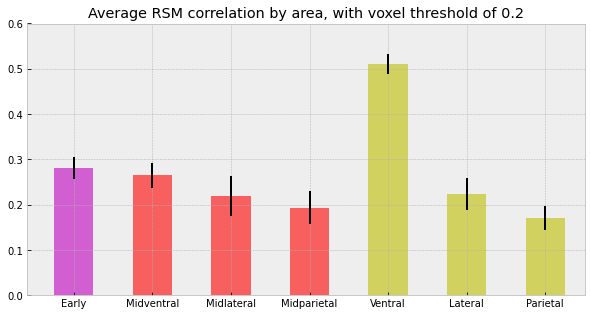

In [36]:
data = mean_rsm_corr_within_subj_within_ROI
error = stats.sem(mean_rsm_corr_within_subj_within_ROI, axis=0)

plt.figure(figsize=(10, 5))
xlocations = np.array(range(data.shape[1]))+.1
width = 0.5
plt.bar(xlocations, np.mean(mean_rsm_corr_within_subj_within_ROI, axis=0), 
        yerr=error, width=width, color = ['m','r','r','r','y','y','y'], alpha = .6)
plt.xticks(xlocations, ROI_names[1:])
plt.xlim(-0.5, xlocations[-1]+width)
plt.title("Average RSM correlation by area, with voxel threshold of " + str(thresh))
plt.gca().get_yaxis().tick_left()
plt.gca().get_xaxis().tick_bottom()
plt.ylim(0,0.6)

plt.savefig('../../../results/figures/RSMcorr_withinROI_withinSubj_voxThresh' + str(int(thresh*100)) + '_abs_zscore.png')


In [37]:
roi_idx = np.arange(0,len(ROI_names)-1)
roi_combs = list(itertools.combinations(roi_idx, 2))

r1_trial_order = [0, 0, 1, 1, 2, 2]
r2_trial_order = [1, 2, 0, 2, 0, 1]

print(roi_combs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


In [38]:
rsm_corr_within_subj_between_ROI = np.zeros((len(subjid),len(list(roi_combs)),6))
rsm_corr_w_subj_b_ROI_same_trials = np.zeros((len(subjid),len(list(roi_combs)),3))


#within subj & between ROI
for sidx, sid in enumerate(subjid):
    
    c = 0
    for comb in roi_combs:
        
        roi_1 = comb[0]
        roi_2 = comb[1]
        
        for r in range(6):
            rsm_corr_within_subj_between_ROI[sidx,c,r] = stats.pearsonr(flat_rsm[sidx,roi_1,:,r1_trial_order[r]],
                                                                        flat_rsm[sidx,roi_2,:,r2_trial_order[r]])[0]
        
        for same in range(3):
            rsm_corr_w_subj_b_ROI_same_trials[sidx,c,same] = stats.pearsonr(flat_rsm[sidx,roi_1,:,same],
                                                                         flat_rsm[sidx,roi_2,:,same])[0]
        
        c += 1

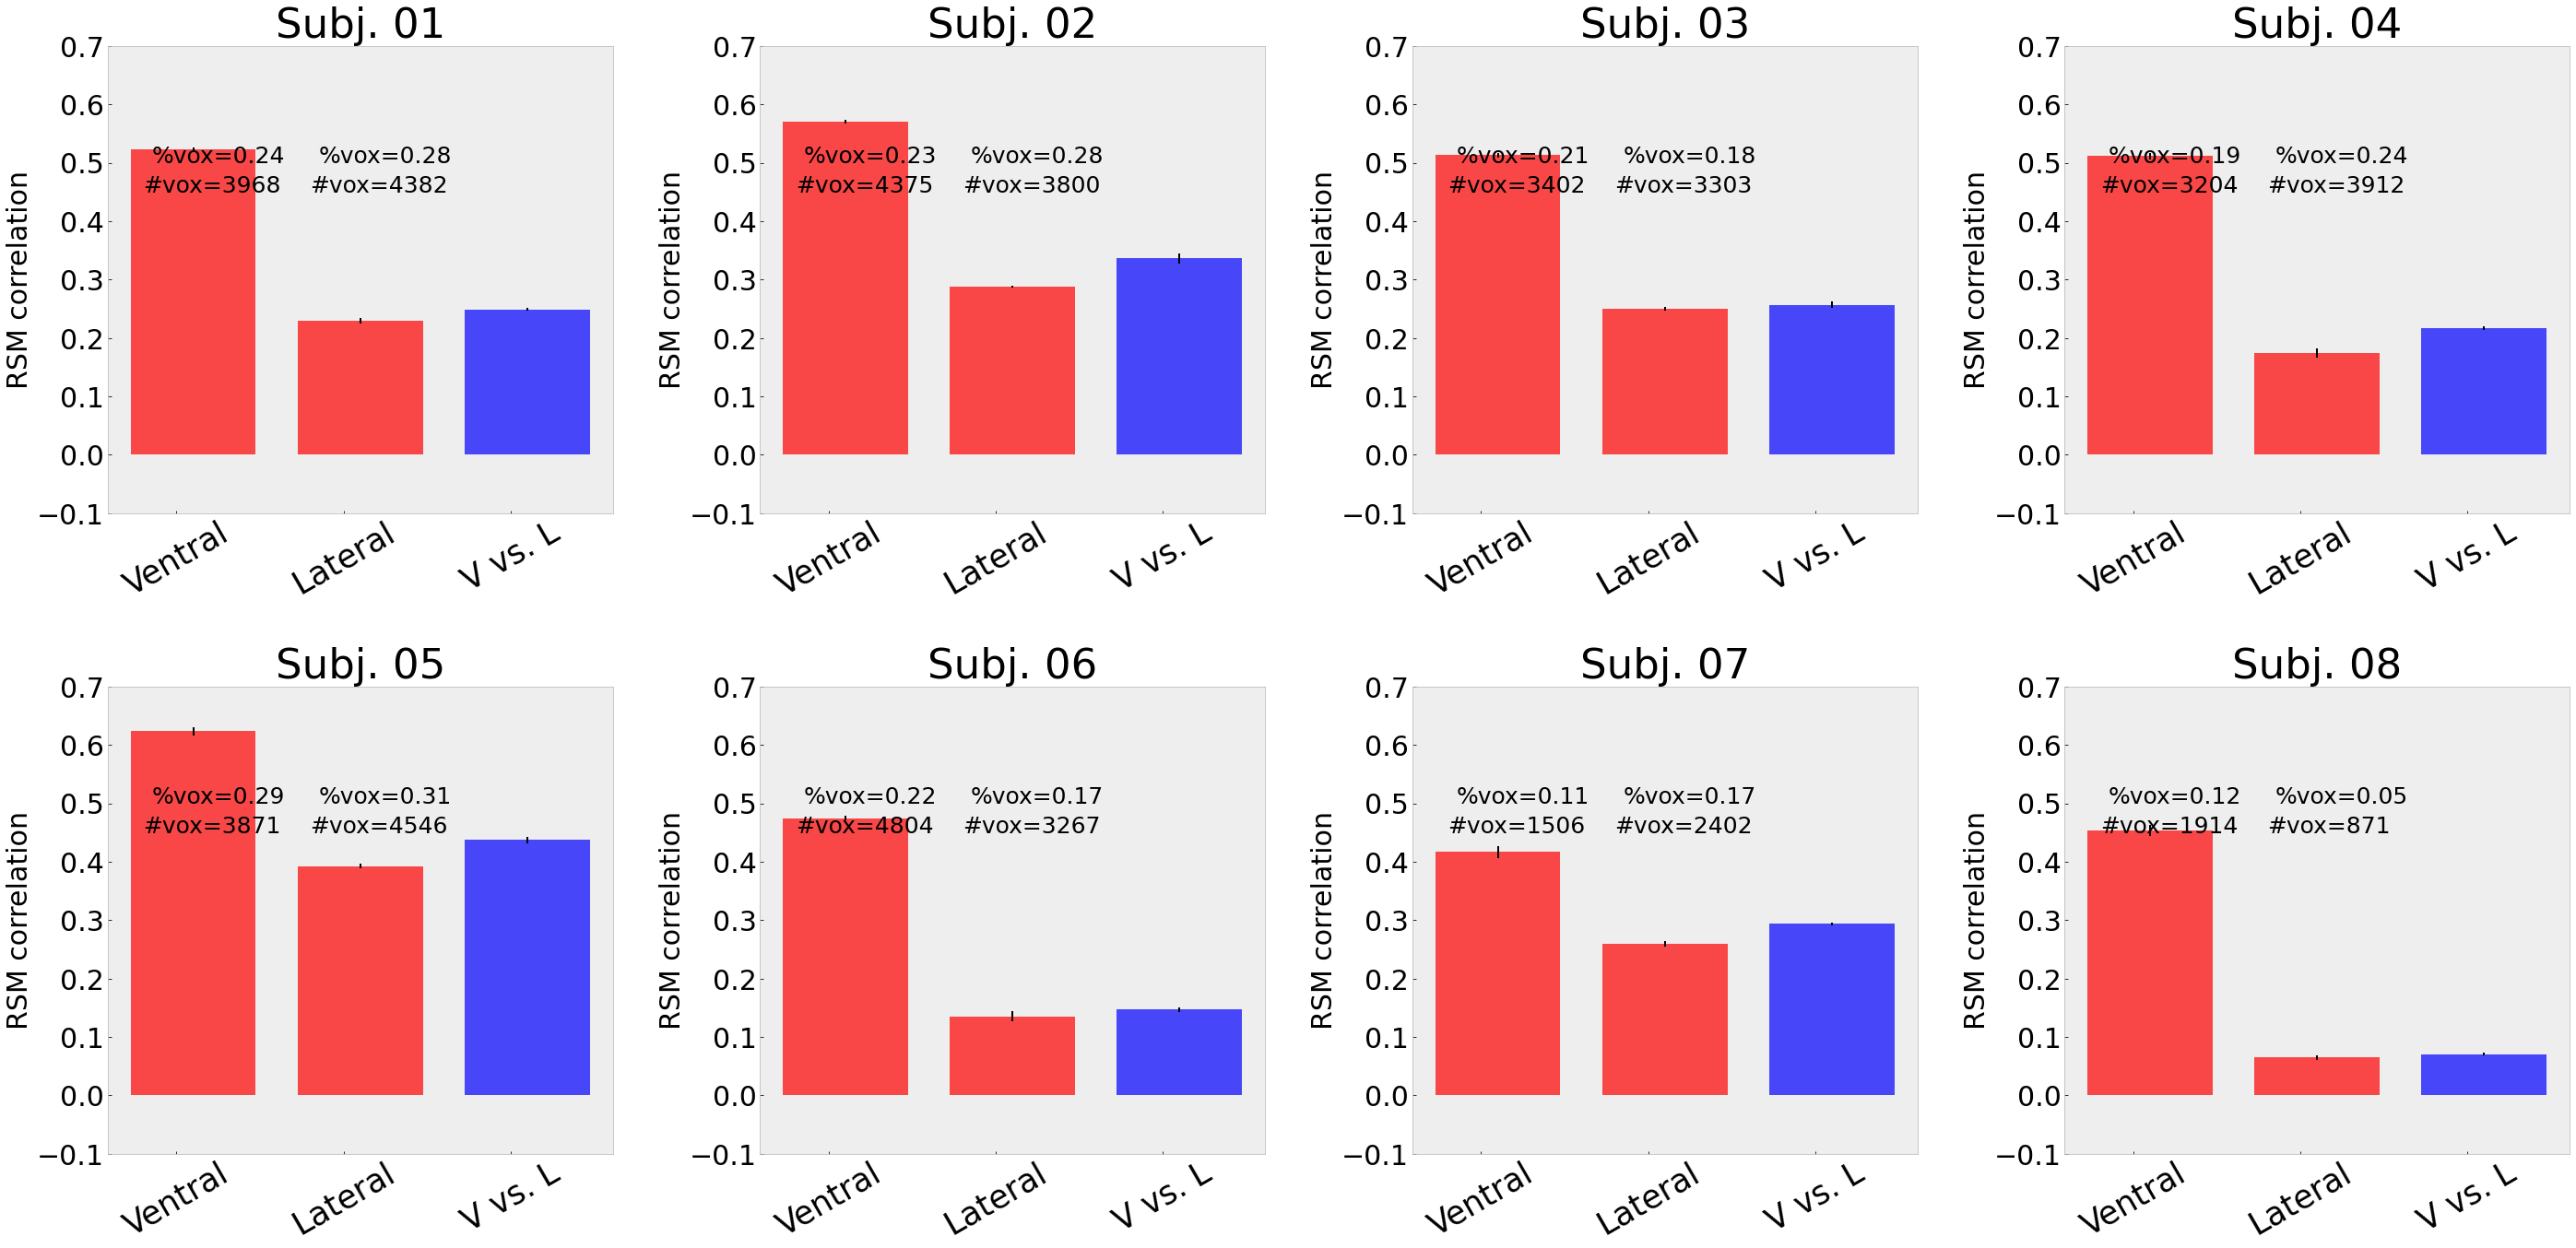

In [39]:
x = np.array(list(map(lambda x: x== (4,5), roi_combs)))
comb_idx = np.where(x)[0][0] #get idx for lateral vs ventral combination

plt.figure(figsize=(40, 20))

for sidx, sid in enumerate(subjid):

    plt.subplot(2, 4, sidx+1)
        
    data = [np.mean(rsm_corr_within_subj_within_ROI[sidx,4,:]), 
            np.mean(rsm_corr_within_subj_within_ROI[sidx,5,:]),
            np.mean(rsm_corr_within_subj_between_ROI[sidx,comb_idx,:])]
    
    error = [stats.sem(rsm_corr_within_subj_within_ROI[sidx,4,:]), 
             stats.sem(rsm_corr_within_subj_within_ROI[sidx,5,:]),
             stats.sem(rsm_corr_within_subj_between_ROI[sidx,comb_idx,:])]
    
    
    xlocations = np.array(range(3))+.1
    width = 0.75
    plt.bar(xlocations, data, yerr=error, width=width, alpha = 0.7, color = ['r', 'r', 'b'])
    
    # Text on the top of each barplot
    vent_vox = thresh_vox[sidx,4]/total_vox[sidx,4]
    lat_vox = thresh_vox[sidx,5]/total_vox[sidx,5]
    label = ['%vox=' + str(round(vent_vox,2)), '%vox=' + str(round(lat_vox,2))]
    label2 = ['#vox=' + str(int(thresh_vox[sidx,4])), '#vox=' + str(int(thresh_vox[sidx,5]))]

    
    for i in range(len(xlocations)-1):
        plt.text(x = xlocations[i]-.25 , y = 0.5, s = label[i], size = 25 )
        plt.text(x = xlocations[i]-.3 , y = 0.45, s = label2[i], size = 25 )
        
    #plt.hist(avg_corrvals[np.where(rh_streams == r)[0]],bins=50,alpha=0.7, rwidth=1, color = c[r])
    
    #plt.xlim(-0.1,1)
    #plt.xticks([fontsize=20])
    plt.xticks(np.arange(0, 3), ['Ventral', 'Lateral', 'V vs. L'], rotation=30, fontsize=35);
    
    plt.ylim(-0.1,0.7)
    plt.yticks(fontsize=30)
    
    plt.ylabel('RSM correlation',size = 30)
    
    title_string = "Subj. "
    title_string += sid
    plt.title(title_string,size = 45)
    
    plt.style.use("bmh")
    plt.grid(False)
    
    plt.tight_layout(pad=5)
    
plt.savefig('../../../results/figures/RSMcorr_ventralVSlateral_voxThresh' + str(int(thresh*100)) + '_abs_zscore.png')
